In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim

from lampe.data import JointLoader, H5Dataset
from lampe.distributions import BoxUniform
from lampe.inference import NRE, NRELoss, BNRELoss, MetropolisHastings
from lampe.plots import nice_rc, corner, mark_point, rank_ecdf
from lampe.utils import GDStep, gridapply
from tqdm import tqdm

## Define the simulator

In [2]:
LOWER = -3 * torch.ones(2)
UPPER = 3 * torch.ones(2)

prior = BoxUniform(LOWER, UPPER)

def slcp(theta):
    # Mean
    mean = torch.tensor([0.7, -2.9])

    # Covariance
    s1 = theta[0] ** 2
    s2 = theta[1] ** 2
    rho = torch.randn(1).squeeze().tanh()

    cov = torch.stack([
        s1**2, rho * s1 * s2,
        rho * s1 * s2, s2**2,
    ]).reshape(2, 2)

    normal = torch.distributions.MultivariateNormal(mean, cov)

    return normal.sample((4,)).view(-1)

## Test the simulator

In [3]:
theta = prior.sample()
x = slcp(theta)

print(theta, x, sep='\n')

tensor([0.0367, 1.7188])
tensor([ 0.6998, -0.3271,  0.7006,  0.7286,  0.7004, -0.0448,  0.6986, -3.2231])


## Create the datasets

In [4]:
loader = JointLoader(prior, slcp, batch_size=256, vectorized=False)

H5Dataset.store(loader, 'data_train.h5', size=2**14, overwrite=True)
H5Dataset.store(loader, 'data_valid.h5', size=2**12, overwrite=True)
H5Dataset.store(loader, 'data_test.h5', size=2**10, overwrite=True)

trainset = H5Dataset('data_train.h5', batch_size=256, shuffle=True)
validset = H5Dataset('data_valid.h5', batch_size=256)
testset = H5Dataset('data_test.h5')

100%|██████████| 1024/1024 [00:00<00:00, 10175.07sample/s]


## Train the models

In [5]:
def train_estimator(balanced: bool):
    # MLP
    estimator = NRE(2, 8, hidden_features=[128] * 3, activation='ELU')

    # Setup optimizer
    if balanced:
        loss = BNRELoss(estimator, 100.0)
    else:
        loss = NRELoss(estimator)

    optimizer = optim.AdamW(estimator.parameters(), lr=1e-3)
    step = GDStep(optimizer)  # gradient descent step with gradient clipping

    # Keep track of the best weights
    best_loss = float('inf')
    best_weights = estimator.state_dict()

    with tqdm(range(128), unit='epoch') as tq:
        for epoch in tq:
            estimator.train()
            
            train_loss = torch.stack([
                step(loss(theta, x))
                for theta, x in trainset
            ]).mean().item()
            
            estimator.eval()

            with torch.no_grad():
                valid_loss = torch.stack([
                    loss(theta, x)
                    for theta, x in validset
                ]).mean().item()

            # Save the weights if they achieve the best validation loss
            if valid_loss < best_loss:
                best_loss = valid_loss
                best_weights = estimator.state_dict()

            tq.set_postfix(train_loss=train_loss, valid_loss=valid_loss)
    
    # Load the weights that achieved the best validation loss
    estimator.load_state_dict(best_weights)

    return estimator

nre_estimator = train_estimator(False)
bnre_estimator = train_estimator(True)

100%|██████████| 128/128 [00:20<00:00,  6.27epoch/s, train_loss=0.671, valid_loss=0.617]


## Compare posteriors obtained with NRE to the ones obtained with BNRE

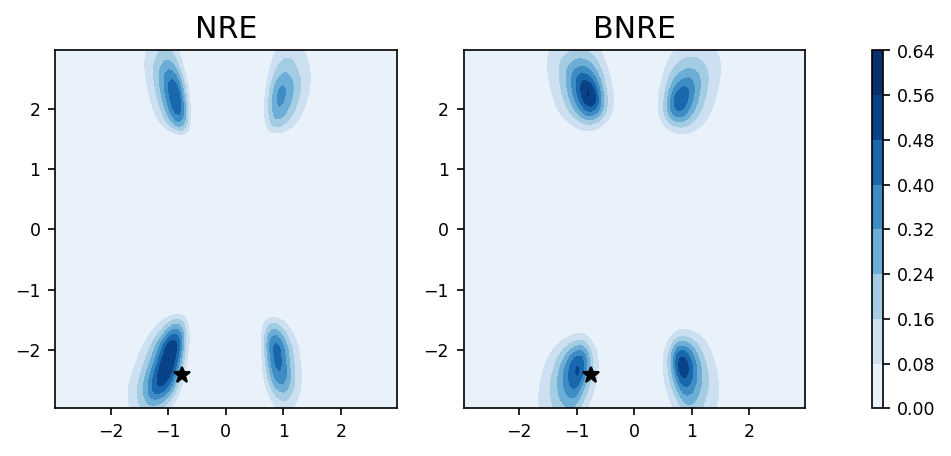

In [6]:
BINS = 100

theta_star = prior.sample()
x_star = slcp(theta_star)

plt.rcParams.update(nice_rc())
fig, axs = plt.subplots(ncols=3, figsize=(6.5, 3.2), gridspec_kw={'width_ratios':[3.2, 3.2, 0.1]})

# NRE
@torch.no_grad()
def posterior(theta):  # p(\theta | x^*)
    return (nre_estimator(theta, x_star) + prior.log_prob(theta)).exp()

theta, probs = gridapply(posterior, bins=BINS, bounds=(LOWER, UPPER))

vmax = probs.max().item()

cplot = axs[0].contourf(theta[..., 0], theta[..., 1], probs, cmap='Blues', vmax=vmax)
axs[0].plot(theta_star[0], theta_star[1], '*', markersize=8, color='k')
axs[0].set_title('NRE')

# BNRE
@torch.no_grad()
def posterior(theta):  # p(\theta | x^*)
    return (bnre_estimator(theta, x_star) + prior.log_prob(theta)).exp()

theta, probs = gridapply(posterior, bins=BINS, bounds=(LOWER, UPPER))

axs[1].contourf(theta[..., 0], theta[..., 1], probs, cmap='Blues', vmax=vmax)
axs[1].plot(theta_star[0], theta_star[1], '*', markersize=8, color='k')
axs[1].set_title('BNRE')

plt.colorbar(cplot, cax=axs[2])
plt.show()

## Compute expected coverage curves

100%|██████████| 1024/1024 [00:11<00:00, 87.69it/s]


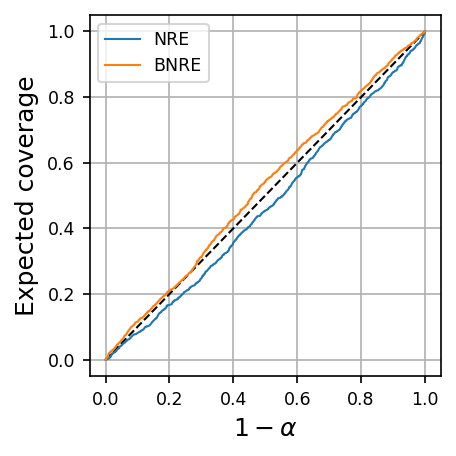

In [7]:
BINS = 100

nre_ranks = []
bnre_ranks = []

for theta_star, x_star in tqdm(testset):
    # NRE
    @torch.no_grad()
    def posterior(theta):
        return (nre_estimator(theta, x_star) + prior.log_prob(theta)).exp()

    # The rank is the proportion of parameters that have a lower poseterior density than
    # the nominal parameters. Hence, the norminal parameters belong to the credible regions
    # at levels 1-rank and below.
    _, probs = gridapply(posterior, bins=BINS, bounds=(LOWER, UPPER))
    rank = probs[probs <= posterior(theta_star)].sum() / probs.sum()
    nre_ranks.append(rank.item())

    # BNRE
    @torch.no_grad()
    def posterior(theta):
        return (bnre_estimator(theta, x_star) + prior.log_prob(theta)).exp()

    _, probs = gridapply(posterior, bins=BINS, bounds=(LOWER, UPPER))
    rank = probs[probs <= posterior(theta_star)].sum() / probs.sum()
    bnre_ranks.append(rank.item())


def get_coverage(ranks):
    # As a sample at a given rank belongs to the credible regions at levels 1-rank and below,
    # the coverage at level 1-alpha is the proportion of samples with ranks alpha and above.
    alpha = np.sort(np.asarray(ranks))
    alpha = np.hstack([0.0, alpha, 1.0])

    return 1 - np.flip(alpha), np.linspace(0.0, 1.0, len(alpha))

fig = plt.figure(figsize=(3.2, 3.2))

plt.plot([0, 1], [0, 1], '--k')
levels, coverage = get_coverage(nre_ranks)
plt.plot(levels, coverage, label='NRE')
levels, coverage = get_coverage(bnre_ranks)
plt.plot(levels, coverage, label='BNRE')

plt.grid()
plt.xlabel(r'$1 - \alpha$')
plt.ylabel('Expected coverage')
plt.legend()
plt.show()